# Computing the nonadiabatic couplings in Kohn-Sham and excited states bases

In this tutorial, we will start computing the nonadiabatic couplings (NACs) from the molecular orbital overlap files obtained in [step2](../../7_step2_cp2k/1_DFT). The NACs will be computed in Kohn-Sham states and also in both single-partcile (SP) and many-body (MB) excited state bases. Finally we will plot the excited states energies vs time and NAC map.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)


2. [Overview of required files](#required_files)


3. [Computing the NACs](#comp_nacs)     

   3.1. [Kohn-Sham basis](#KS)
   
   3.2. [Excited state basis](#excited_states)
   

4. [Plotting the results](#plotting)

    4.1. [NAC distribution](#nac_dist)
    
    4.2. [Energy vs time](#ene_time)
    
    4.3. [NAC map](#nac_map)
    
    4.4. [Excitation analysis](#exc_anal)
    
    4.5. [Average partial density of states](#ave_pdos)
    
      * 4.5.1. [Plot pDOS for all atoms angular momentums](#ave_pdos_1)
      
      * 4.5.2. [Plot pDOS for atoms with no angular momentum component](#ave_pdos_2)

### A. Learning objectives

* To be able to compute the NACs in Kohn-Sham and excited state bases
* To be able to plot the NACs distribution 
* To be able to plot the computed excited states energies vs time
* To be able to plot the NAC map
* To be able to plot the average CI coefficients
* To be able to plot the average partial density of states

### B. Use cases

* [Computing the NACs](#comp_nacs)


* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `CP2K_methods`
    - [`read_cp2k_tddfpt_log_file`](#exc_anal)
  - `data_stat`
    - [`cmat_distrib`](#nac_dist)
  - `workflows`
    - `nbra`
      - [`step2_many_body`](#exc_anal)
        - [`normalize_ci_coefficients`](#exc_anal)
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `units`
    - `au2ev`


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library so that we can read and check the orthonormality of the data.
Import `numpy`, `scipy.sparse`, `CP2K_methods`, `data_stat`, `data_io`, `units`, `step2_many_body`, and `step3` modules. Also, `glob` will be needed to find specific types of files.

In [1]:
import os
import sys
import time
import glob
import math
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py.workflows.nbra import step3, step2_many_body
from libra_py import CP2K_methods, units, data_stat, data_io

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

* `../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/res`

The MO overlap files are needed and stored in this folder.

* `../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_logfiles`

All of the logfiles obtained from the electronic structure calculations of CP2K. These files will be needed to find the Kohn-Sham HOMO index and also extract the the TD-DFT data for each step.

## 3. Computing the NACs <a name="comp_nacs"></a>
[Back to TOC](#toc)

### 3.1. Kohn-Sham basis <a name="KS"></a>

The `libra_py.workflow.nbra.step3.run_step3_ks_nacs_libint(params)` computes the NACs between pairs of Kohn-Sham states using the molecular orbital overlaps. 

Libra stores the overlap data in 2-spinor format as follows:

<div>
<img src="./active_space_0.png" width="500"/>
</div>

With no spin-orbit couplings, two blocks of the matrix is zero. Since most of the elements of the overlap matrices are zero, we use the `scipy.sparse` library for storing and loading them. 

The paramters for this function are as follows:

`params['lowest_orbital']`: The lowest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['highest_orbital']`: The highest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['num_occ_states']`: The number of occupied orbitals to be considered from HOMO to lower occupied states. This value is defined by user.

`params['num_unocc_states']`: The number of unoccupied orbitals to be considered from LUMO to higher unoccupied states. This value is defined by user.

The two values above are used to create an active space which then will be used to select the elements from the MO overlap and 
energy matrices. 

`params['use_multiprocessing']`: A boolean flag to use the multiprocessing library of Python or not.

`params['nprocs']`: The number of processors to be used for the calculations. Libra will use this only if the `params['use_multiprocessing']` 
is set to `True`.

`params['time_step']`: The time-step used in the calculations in `fs`.

`params['es_software']`: The name of the software package used to compute the electronic structure calculations. This will be used to generate the HOMO 
index of that system so it can build the active space.

`params['path_to_npz_files']`: The full path to the MO overlap files.

`params['logfile_directory']`: The full path to the folder where all the log files are stored.

`params['path_to_save_ks_Hvibs']`: The full path to the folder in which the NACs between the Konh-Sham states are stored.

`params['start_time']`: The start time-step.

`params['finish_time']`: The finish time-step.

`params['apply_phase_correction']`: A boolean flag for applying phase-correction algorithm.

`params['apply_orthonormalization']`: A boolean flag for applying the orthonormalization algorithm.

`params['do_state_reordering']`: If this value is set to `1` or `2`, the state-reordering will be applied to overlap matrices.

`params['state_reordering_alpha']`: The state-reordering alpha value if the `params['do_state_reordering'] = 2`.

`params['nac_algo']`: selection of a method to compute NACs. `0` is for Hamess-Shiffer-Tully (HST), finite difference (the default) and `1` is Meek-Levine NPI approach.

After setting all the above paramters, the calculations are run using `step3.run_step3_ks_nacs_libint(params)`.


In fact, we generate a new active space from the raw data we obtained from step2, and make a new set of 
overlap matrices that some corrections are applied such as state reordering and phase-correction. Then, one can use the 
corrected overlaps for the computation of the NACs between excited states, using the `step3.run_step3_sd_nacs_libint` function. 
A schematic of the workflow for selecting new active space is shown below:

<div>
<img src="./active_space_1.png" width="1000"/>
</div>


Note: When creating active spaces, the prior knowledge of the KS HOMO index by user is advantageous.

In [7]:
params_ks = {
              'lowest_orbital': 90-10, 'highest_orbital': 90+11, 'num_occ_states': 10, 'num_unocc_states': 10,
              'use_multiprocessing': True, 'nprocs': 8, 'time_step': 1.0, 'es_software': 'cp2k',
              'path_to_npz_files': '/projects/academic/cyberwksp21/Students/ppandeya/project/LIBRA/step2/res',
              'logfile_directory': '/projects/academic/cyberwksp21/Students/ppandeya/project/LIBRA/step2/all_logfiles',
              'path_to_save_ks_Hvibs': os.getcwd()+'/res-ks-DFT',
              'start_time': 1200, 'finish_time': 1223,
              'apply_phase_correction': True, 'apply_orthonormalization': True,
              'do_state_reordering': 2, 'state_reordering_alpha':0, 'nac_algo': 0
            }

#### For KS states - Applying correction to KS overlaps and computing the NACs in KS space
step3.run_step3_ks_nacs_libint(params_ks)

Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step        12021203120112061205120412001207







Done with stepDone with stepDone with stepDone with step Done with stepDone with step Done with stepDone with step  1201  1203  12021206 12051200 12041207  . Elapsed time:  . Elapsed time:  . Elapsed time:. Elapsed time: . Elapsed time:. Elapsed time: . Elapsed time:. Elapsed time:  0.7450144290924072  0.7431323528289795  0.75108170509338380.7387750148773193
0.74425721168518070.7658367156982422
0.75573277473449710.7474305629730225

Computing orthonormalization of St matrices in step
Computing orthonormalization of St matrices in step


Co

### 3.2. Excited state basis <a name="excited_states"></a>

The NACs can also be computed between excited states. These include the single-particle and many-body bases which the latter is obtained from the
TD-DFT calculations. First, we need to compute the overlap between excited state Slater-determinants (SDs) then they will be used to compute the NACs
between them. For many-body states, the configuration interaction coefficietns will also be used. We will consider both single-particle 
and many-body for DFT calculations but only single-particle for xTB.

To run the calculations `step3.run_step3_sd_nacs_libint(params)` function will be used. Some parameters are common with the ones used to run `step3.run_step3_ks_nacs_libint(params)`.

There are different ways of defining the excited states SDs (the single-particle excited state basis). The first is through 
defining the `num_occ_states` and `num_unocc_states` in which Libra
will start making the SDs from all of the occupied states (starting from `HOMO-num_occ_states+1`) to all of the unoccupied states (ends
to `LUMO+num_unocc_states-1`). Also, if the unrestricted spin calculation flag is set to `True`, the SDs will be made for both alpha and beta spin channels. 

For example, if you want to build the electron-only excitation basis, you need to set `params['num_occ_states'] = 1` and set `params['num_unocc_states']`
to a value less than the number of unoccupied orbitals that was considered in the computation of overlaps. This will generate all the electron-only
excitation from HOMO to unoccupied states.

If the TD-DFT calculations has been done, then Libra will go over all log files and 
generate all the SDs used for all the steps and therefore the definition of these SDs is automatic and Libra will replace the `num_occ_states` and
`num_unocc_states` itself based on the SDs that were generated from the TD-DFT log files. 



Other parameters needed to run the `step3.run_step3_sd_nacs_libint(params)` function are as follows:

`params['isUKS']`: A boolean flag for unrestricted spin calculations.

`params['is_many_body']`: If set to `True`, the NACs will be computed between pairs of many-body (TD-DFT) states. Also, the NACs between single-particle 
SDs obtained from the TD-DFT results will be computed as well. Otherwise, only single-particle NACs will be computed only for the SDs obtained from
`num_occ_states` and `num_unocc_states`. This will be used for xTB calculations in which no TD-DFT is performed.

`params['number_of_states']`: The number of TD-DFT states to consider. This value should not exceed the number of requested TD-DFT states in the CP2K
calculations.

`params['tolerance']`: A lower bound for selection of the excitation with configuration interaction coefficients higher than this value.

`params['verbosity']`: An integer value showing the printing level. The default is set to 0. Higher values will print more data on terminal.

`params['sorting_type']`: After defining the SDs, Libra will sort them either based on `'energy'` or `'identity'`.

In this example, we use the corrected KS time-overlaps that we generated above in the `res-ks-DFT` directory. If `is_many_body` is set to `False`, Libra will generate all the single-particle excitations from all the occupied states from HOMO to `HOMO-params['num_occ_states']+1` states to all `HOMO+params['num_unocc_states']` unoccupied states which counts to a total number of excitations of `params['num_occ_states'] x params['num_unocc_states']`.

<div>
<img src="./active_space_2.png" width="1000"/>
</div>

Note that here the KS HOMO index is 24.

In [8]:
#### For excited states - Computing the excited states SDs and their overlaps and NACs
params_mb_sd = {
          'lowest_orbital': 90-params_ks['num_occ_states']+1, 'highest_orbital': 90+params_ks['num_unocc_states'],
          'num_occ_states': 10, 'num_unocc_states': 10,
          'isUKS': 0, 'number_of_states': 10, 'tolerance': 0.01, 'verbosity': 0,
          'use_multiprocessing': True, 'nprocs': 12,
          'is_many_body': True, 'time_step': 1.0, 'es_software': 'cp2k',
          #'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/res',
          'path_to_npz_files': os.getcwd()+'/res-ks-DFT',
          'logfile_directory': '/projects/academic/cyberwksp21/Students/ppandeya/project/LIBRA/step2/all_logfiles',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-mb-sd-DFT',
          'outdir': os.getcwd()+'/res-mb-sd-DFT',
          'start_time': 1200, 'finish_time': 1223, 'sorting_type': 'identity',
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0, 'nac_algo': 0
         }


step3.run_step3_sd_nacs_libint(params_mb_sd)

sd_unique_basis is: [[[61, 62], 'alp'], [[57, 62], 'alp'], [[59, 62], 'alp'], [[60, 63], 'alp'], [[60, 62], 'alp'], [[61, 63], 'alp'], [[61, 64], 'alp'], [[56, 62], 'alp'], [[58, 62], 'alp'], [[61, 65], 'alp'], [[60, 65], 'alp'], [[60, 64], 'alp'], [[53, 62], 'alp'], [[58, 63], 'alp'], [[60, 66], 'alp'], [[61, 67], 'alp'], [[61, 68], 'alp'], [[55, 62], 'alp'], [[61, 66], 'alp'], [[52, 62], 'alp'], [[59, 63], 'alp'], [[57, 63], 'alp'], [[54, 62], 'alp']]
sd_states_reindexed is: [[1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 10, -10], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 11, -10], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 11, -6, 7, -7, 8, -8, 9, -9, 10, -10], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 11, -8, 9, -9, 10, -10], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 12, -9, 10, -10], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 11, -9, 10, -10], [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6, 7, -7, 8, -8, 9, -9, 12, -

Applying phase-correction to St_ci matrix of step 12
Applying phase-correction to St_ci matrix of step 13
Applying phase-correction to St_ci matrix of step 14
Applying phase-correction to St_ci matrix of step 15
Applying phase-correction to St_ci matrix of step 16
Applying phase-correction to St_ci matrix of step 17
Applying phase-correction to St_ci matrix of step 18
Applying phase-correction to St_ci matrix of step 19
Applying phase-correction to St_ci matrix of step 20
Applying phase-correction to St_ci matrix of step 21
Done with applying phase-correction to St_ci matrices. Elpased time: 0.9095010757446289


## 4. Plotting the results <a name='plotting'></a>
[Back to TOC](#toc)

### 4.1. NAC distribution <a name='nac_dist'></a>

One of the intuitive ways to visualize the NACs is to plot the distribution of the NACs. Here we plot them for SP and MB excited states. A smoother distribution plot is obtained if more steps are involved.

In [11]:
E = sp.load_npz("res-mb-sd-DFT/Hvib_sd_1200_re.npz").todense()


<IPython.core.display.Javascript object>


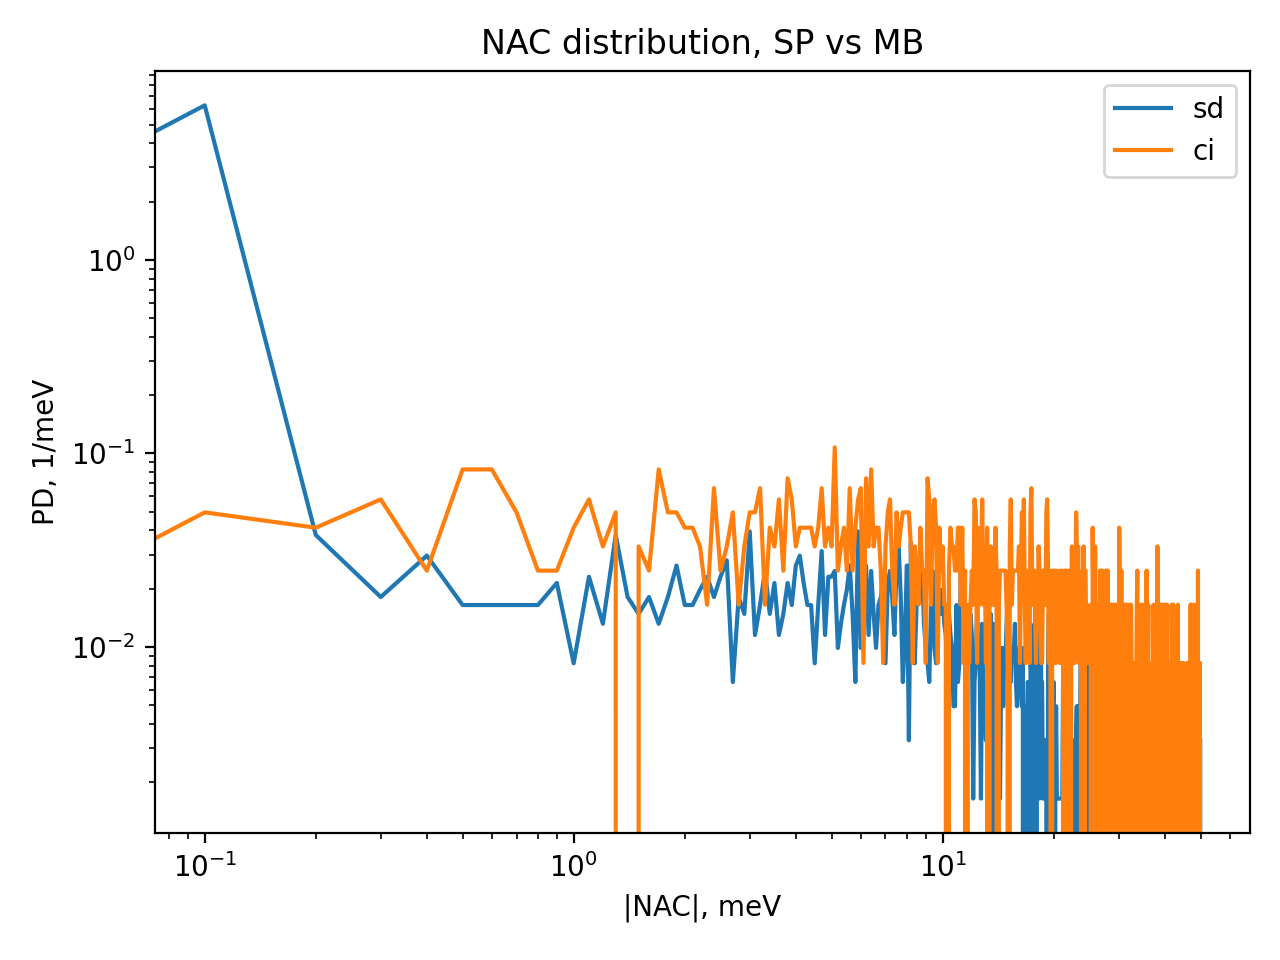

In [10]:
%matplotlib notebook

for basis in ['sd','ci']:
    nac = []
    nac_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp, dens, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp, dens, label=basis)
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution, SP vs MB')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
# plt.savefig('nac_dist_1.jpg', dpi=600)

### 4.2. Energy vs time <a name='ene_time'></a>
Here, we plot the excited states energy vs time. Since the excited states were sorted by their `'identity'` it is easy to visualize the states energies crossings.

<IPython.core.display.Javascript object>


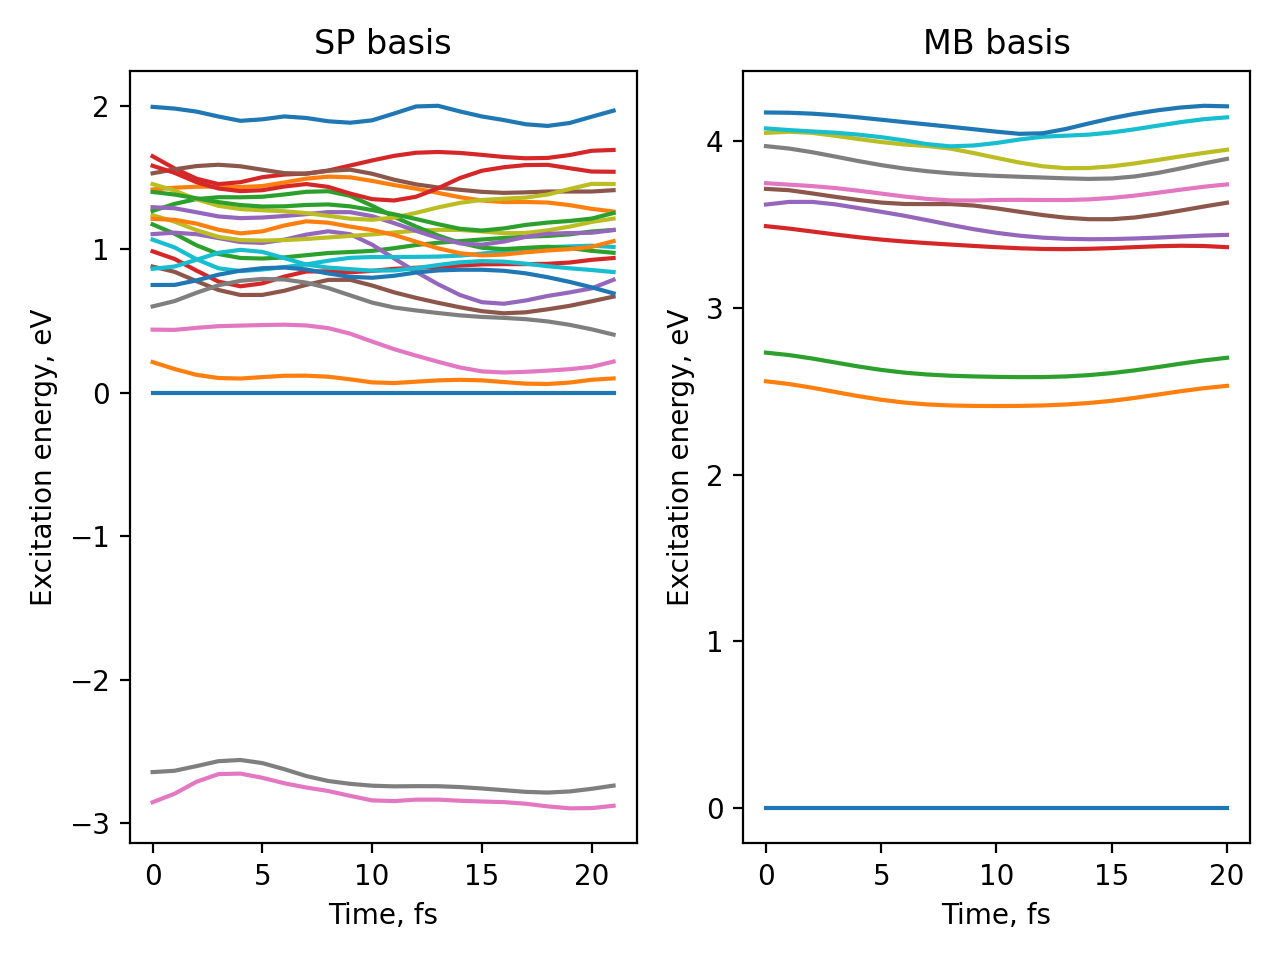

In [12]:
%matplotlib notebook
titles = ['SP basis', 'MB basis']
plt.figure()
for c, basis in enumerate(['sd','ci']):
    plt.subplot(1,2,c+1)
    energy_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*re*')
    energy_files = data_io.sort_hvib_file_names(energy_files)
    #print('Sorted energy files are:', energy_files)
    dt = 1.0 # fs
    energies = []
    for file in energy_files:
        energies.append(np.diag(sp.load_npz(file).todense().real))
    energies = np.array(energies)*units.au2ev
    md_time = np.arange(0,energies.shape[0]*dt,dt)
    for i in range(energies.shape[1]): # 
        plt.plot(md_time, energies[:,i]-energies[:,0])
    
    plt.title(titles[c])
    plt.ylabel('Excitation energy, eV')
    plt.xlabel('Time, fs')
    plt.tight_layout()

### 4.3. NAC map <a name='nac_map'></a>
Another way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`.

<IPython.core.display.Javascript object>


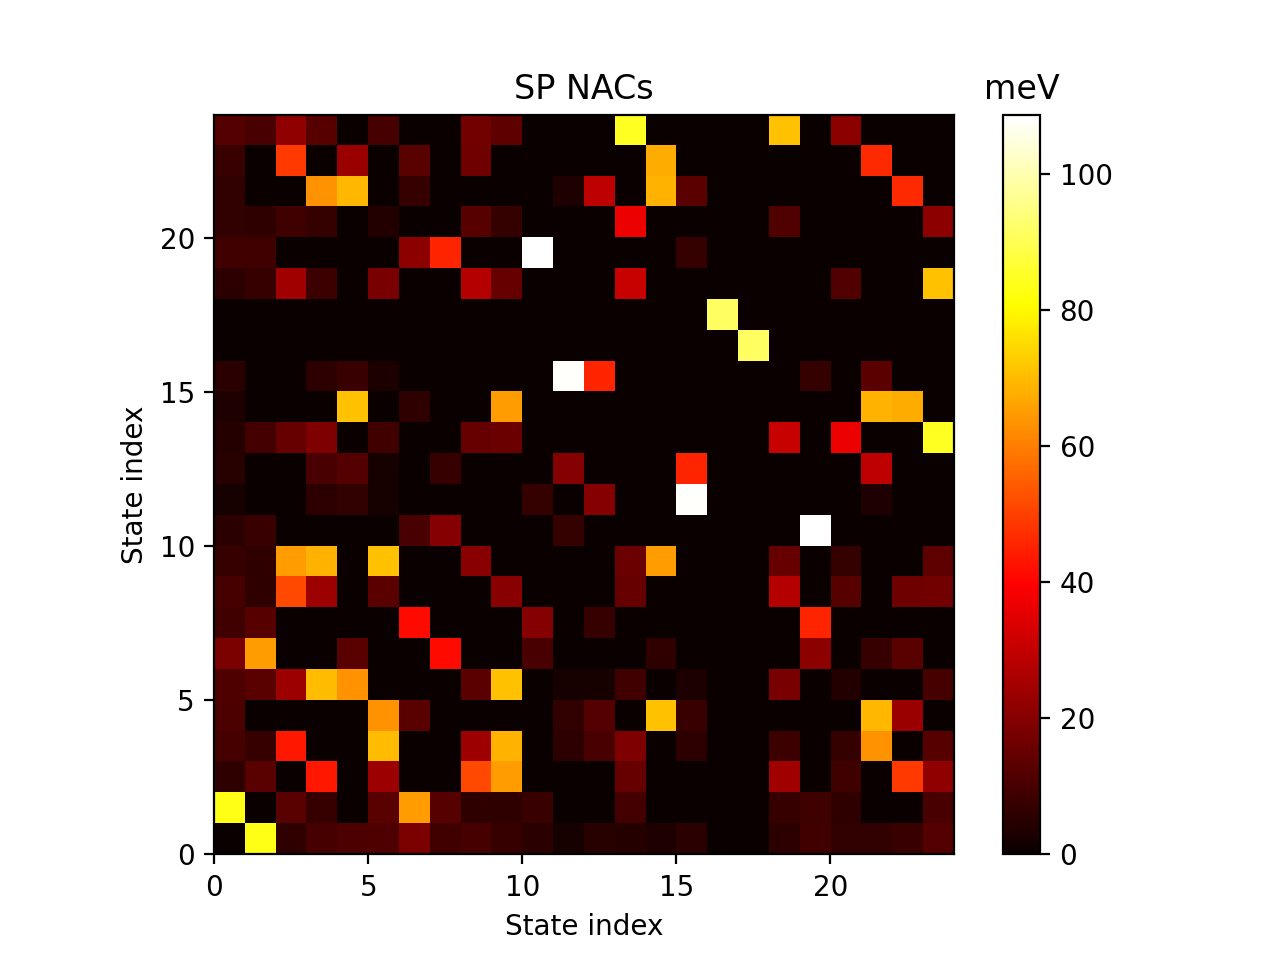

Text(0.5, 1.0, 'SP NACs')

In [13]:
%matplotlib notebook
plt.figure()
nac_files = glob.glob('res-mb-sd-DFT/Hvib_sd*im*')
for c, nac_file in enumerate(nac_files):
    nac_mat = sp.load_npz(nac_file).todense().real
    if c==0:
        nac_ave = np.zeros(nac_mat.shape)
    nac_ave += np.abs(nac_mat)
nac_ave *= 1000*units.au2ev/c
nstates = nac_ave.shape[0]
plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
plt.xlabel('State index')
plt.ylabel('State index')
plt.colorbar().ax.set_title('meV')
plt.title('SP NACs')

<IPython.core.display.Javascript object>


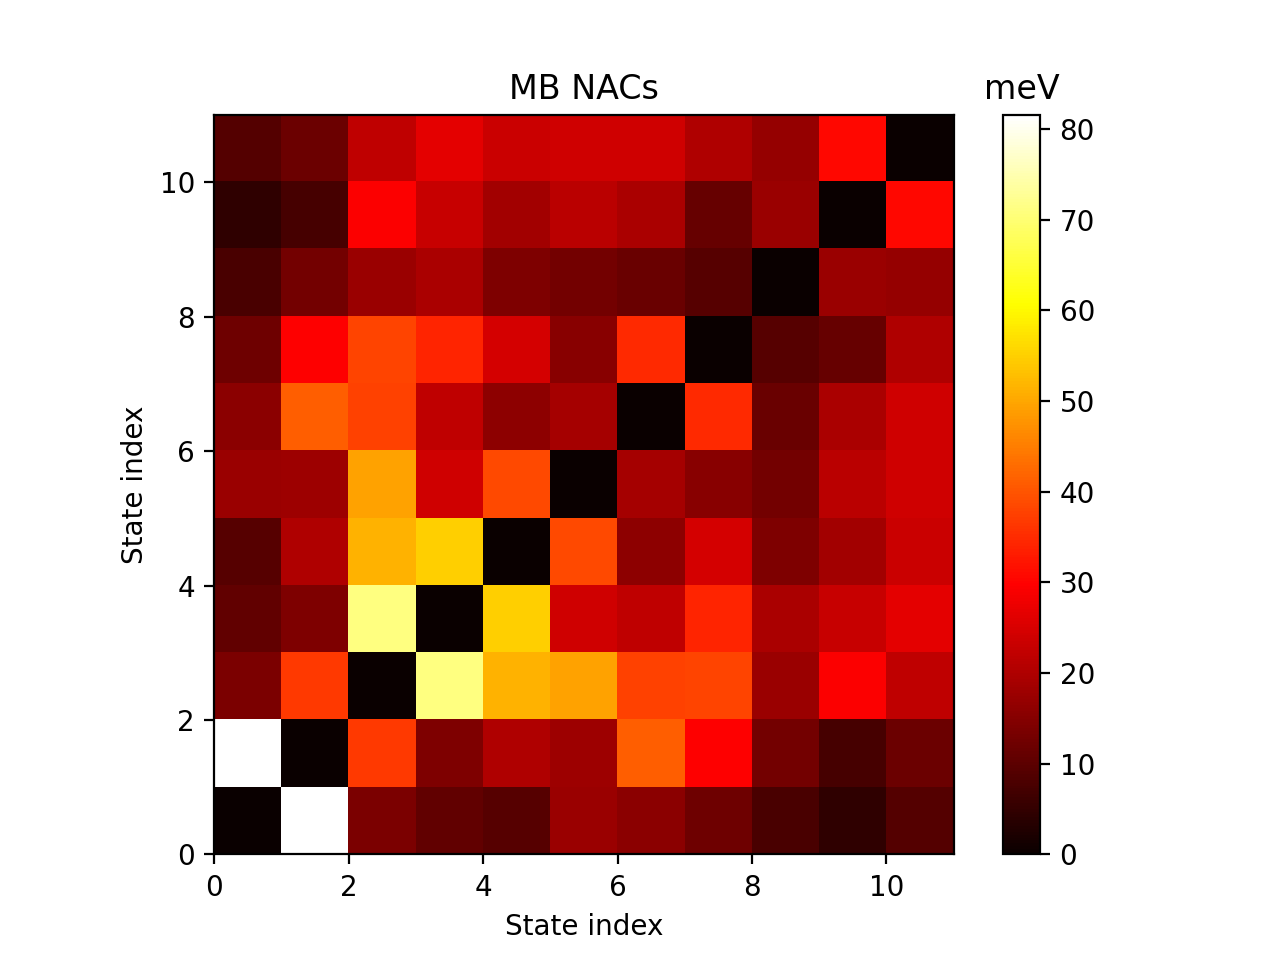

Text(0.5, 1.0, 'MB NACs')

In [14]:
%matplotlib notebook
nac_files = glob.glob('res-mb-sd-DFT/Hvib_ci*im*')
for c, nac_file in enumerate(nac_files):
    nac_mat = sp.load_npz(nac_file).todense().real
    if c==0:
        nac_ave = np.zeros(nac_mat.shape)
    nac_ave += np.abs(nac_mat)
nac_ave *= 1000*units.au2ev/c
nstates = nac_ave.shape[0]
plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
plt.xlabel('State index')
plt.ylabel('State index')
plt.colorbar().ax.set_title('meV')
plt.title('MB NACs')

### 4.4. Excitation analysis <a name='exc_anal'></a>
Here, we average the CI coefficients for each TD-DFT excited states over the MD trajectory. This shows the excited states degree of mixing. This code is adopted from [here](https://github.com/AkimovLab/Project_CsPbI3_MB_vs_SP/blob/master/cubic/excitation_analysis/excitation_analysis.py) written by Brendan Smith with some modifications.

We first need to define a dictionary which has exactly the same parameters as in `params_md_sd`. Other parameters that needs to be defined are as follows:

`logfiles`: A list of all log files which is obtained from `glob.glob`.

`nsds`: Number of SDs to be considered for each excited state.

`colors`: The colors which are in order of the SDs. For example, the `green` color is for the first excitation that appears in the excited states analysis section in CP2K log files.

The black lines show the error bars which are computed with a confidence interval coefficient of 1.96 which shows the confidence interval of $95\%$. The error bars are computed as follows:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $Z$ is the confidence interval coefficient, $s$ is the standard deviation of the $c_i^2$ values, and $N$ is the number of samples. We will use this formula over the tutorials for step4 as well.

<IPython.core.display.Javascript object>


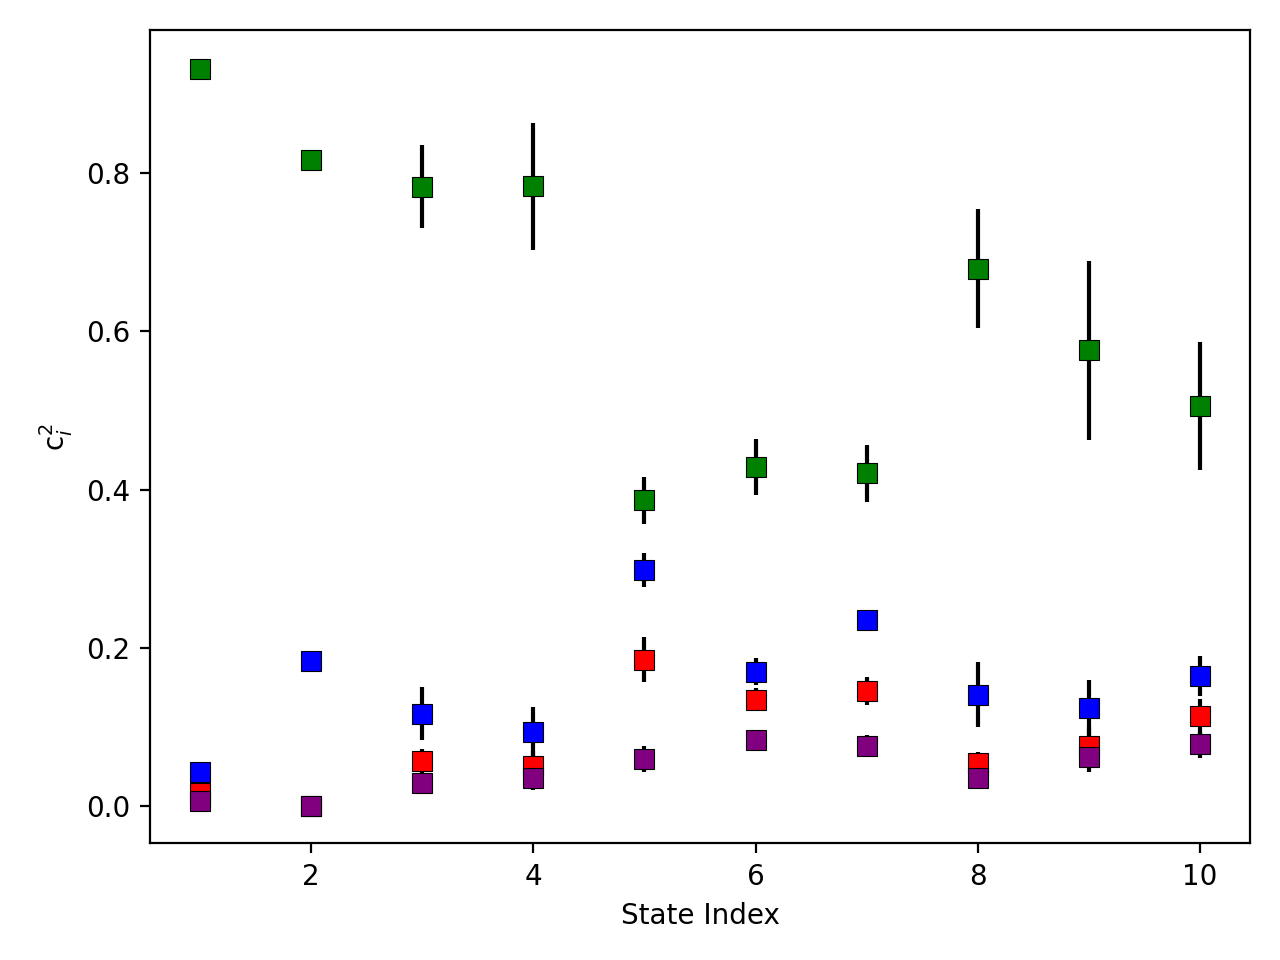

In [15]:
%matplotlib notebook
logfiles = glob.glob(F'{params_mb_sd["logfile_directory"]}/*.log')
params = params_mb_sd
nsds = 4
colors = ['green','blue','red','purple']
ci_coeffs = []
for logfile in logfiles:
    params.update({"logfile_name": logfile})
    excitation_energies, ci_basis_raw, ci_coefficients_raw_unnorm, spin_components = CP2K_methods.read_cp2k_tddfpt_log_file( params ) 
    ci_coefficients_raw_norm = step2_many_body.normalize_ci_coefficients(ci_coefficients_raw_unnorm)
    for j in range(len(ci_coefficients_raw_norm)):
        for k in range(len(ci_coefficients_raw_norm[j])):
            ci_coefficients_raw_norm[j][k] = ci_coefficients_raw_norm[j][k]**2
    ci_coeffs.append(ci_coefficients_raw_norm)


nsteps = len(ci_coeffs)
nstates = params["number_of_states"]

coeffs = []
coeffs_avg   = []
coeffs_error = []


for state in range(nstates):

    coeffs.append( [] )
    coeffs_avg.append( [] )
    coeffs_error.append( [] )

    for sd in range( nsds ):

        coeffs[state].append( [] )
        coeffs_avg[state].append( [] )
        coeffs_error[state].append( [] )

        for step in range( nsteps ):
            if len( ci_coeffs[step][state] ) < nsds and sd > len( ci_coeffs[step][state] )-1:
                coeffs[state][sd].append( 0.0 )
            else:
                coeffs[state][sd].append( ci_coeffs[step][state][sd] )
     
        mb_coeff_avg, mb_coeff_std = data_stat.scalar_stat( coeffs[state][sd] )
        coeffs_avg[state][sd].append( mb_coeff_avg )
        coeffs_error[state][sd].append( 1.96 * mb_coeff_std / math.sqrt(nsteps) )
  
        plt.plot(     state+1, mb_coeff_avg, color="black", marker='s', markerfacecolor=colors[sd], markeredgewidth=0.4, markersize=7)
        plt.errorbar( state+1, mb_coeff_avg, yerr=coeffs_error[state][sd], linestyle="None", color='black')


# plt.ylim(0,1)
plt.xlabel('State Index')
plt.ylabel('c$_{i}^2$')
plt.tight_layout()

### 4.5. Average partial density of states <a name='ave_pdos'></a>
In this section, we will plot the average partial density of states (pDOS) over the MD trajectory. There are two ways to take the average of the pDOS:

1- Average all the pDOS files and then convolve the average pDOS for each element.
2- Convolve the pDOS files and then take the average for each element.

We choose the first one due to two reasons. First, the computational cost is much lower and we only need one convolution. Second is that averaging over the grid points (using the method 2) is dependent on the number of grid points we use for convolution which again adds to the complexity of the procedure. 

Here, we will use normalized Gaussian function for weighting the pDOS values and summing them.

$$f(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

This function is defined in the `gaussian_function` below. To apply this to a vector of numbers and sum all the weighted Gaussians, we use the `gaussian_function_vector` which will be used for pDOS plots.

In [10]:
def gaussian_function(a, mu, sigma, num_points, x_min, x_max):
    pre_fact = (a/sigma)/(np.sqrt(2*np.pi))
    x = np.linspace(x_min, x_max, num_points)
    x_input = np.array((-1/2)/(np.square(sigma))*np.square(x-mu))
    gaussian_fun = pre_fact*np.exp(x_input)
    
    return x, gaussian_fun
    
def gaussian_function_vector(a_vec, mu_vec, sigma, num_points, x_min, x_max):
    for i in range(len(a_vec)):
        if i==0:
            sum_vec = np.zeros(num_points)
        energy_grid, conv_vec = gaussian_function(a_vec[i], mu_vec[i], sigma, num_points, x_min, x_max)
        sum_vec += conv_vec
    return energy_grid, sum_vec


#### 4.5.1. Plot pDOS for all atoms angular momentums <a name='ave_pdos_1'></a>

In this part, we plot the pDOS for all of the angular momentum components of each atom. This is done by using the `orbital_cols`. In fact, the `orbital_cols` is related to `orbitals`. For example, for `s` orbital, we consider the 3rd index and for `p` orbital, we sum the columns from 4 to 6 (`range(4,7)`). Here we want to show how the code works and how the you can modify that based on your project. In the next section, we will show the pDOS only for atoms and sum all the components in each row of the pdos file. Other parameters are as follows:

`atoms`: The atoms names which will be used in the labeling and plotting. The atoms order should be exactly the same as appear in the `.pdos` files. For example, the `*k1*.pdos` files contain the pDOS data for `Ti` atom and `*k2*.pdos` files contain the data for the `O` atom.

`npoints`: The number of grid points for making the Gaussian functions. Note that, this value should be more than the number of states in the `.pdos` files.

`sigma`: The standard deviation in eV.

`shift`: This value shifts the minimum and maximum energy found in the `pdos_ave` and will extend the boundaries from both sides by `shift`eV.

Finally, we will plot the total density of states. Note that the HOMO energy level is set to zero.

<IPython.core.display.Javascript object>


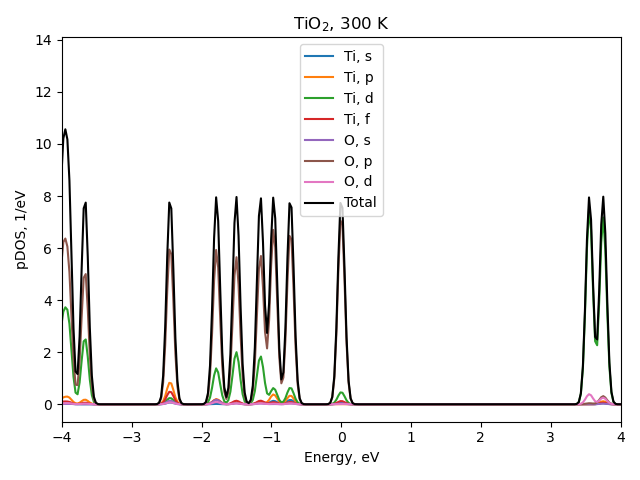

In [11]:
%matplotlib notebook
path_to_all_pdos = os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_pdosfiles'
atoms = ['Ti', 'O']
orbitals_cols = [[3], range(4,7), range(7,12), range(12,19)]
orbitals = ['s','p','d','f']
npoints = 4000
sigma = 0.05 # eV
shift = 2.0 # eV
ave_pdos_convolved_all = []
for c1,i in enumerate([1,2]):
    pdos_files = glob.glob(path_to_all_pdos+F'/*k{i}*.pdos')
    for c2, pdos_file in enumerate(pdos_files):
        pdos_mat = np.loadtxt(pdos_file)
        if c2==0:
            pdos_ave = np.zeros(pdos_mat.shape)
        pdos_ave += pdos_mat
    pdos_ave /= c2+1
    pdos_ave[:,1] *= units.au2ev
    e_min = np.min(pdos_ave[:,1])-shift
    e_max = np.max(pdos_ave[:,1])+shift
    homo_level = np.max(np.where(pdos_ave[:,2]==2.0))
    homo_energy = pdos_ave[:,1][homo_level]
    for c3, orbital_cols in enumerate(orbitals_cols):
        try:
            sum_pdos_ave = np.sum(pdos_ave[:,orbital_cols],axis=1)
            ave_energy_grid, ave_pdos_convolved = gaussian_function_vector(sum_pdos_ave, pdos_ave[:,1], sigma,
                                                                               npoints, e_min, e_max)
            ave_pdos_convolved_all.append(ave_pdos_convolved)
            pdos_label = atoms[c1]+F', {orbitals[c3]}'
            plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved, label=pdos_label)
        except:
            pass


ave_pdos_convolved_total = np.sum(np.array(ave_pdos_convolved_all),axis=0)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend()
plt.xlim(-4,4)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('TiO$_2$, 300 K')
plt.tight_layout()

#### 4.5.2. Plot pDOS for atoms with no angular momentum component <a name='ave_pdos_2'></a>
As you can see we have removed the `for` loop for the `orbital_cols` and in the `try` section we have set `sum_pdos_ave = np.sum(pdos_ave[:,3::],axis=1)` which will sum all the columns from 3rd index (`pdos_ave[:,3::]`).

<IPython.core.display.Javascript object>


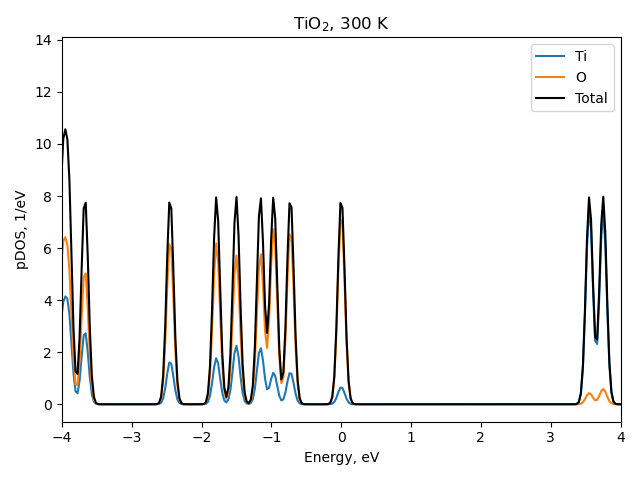

In [12]:
%matplotlib notebook
path_to_all_pdos = os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_pdosfiles'
atoms = ['Ti', 'O']
npoints = 4000
sigma = 0.05
shift = 2.0 # eV
ave_pdos_convolved_all = []
for c1,i in enumerate([1,2]):
    pdos_files = glob.glob(path_to_all_pdos+F'/*k{i}*.pdos')
    for c2, pdos_file in enumerate(pdos_files):
        pdos_mat = np.loadtxt(pdos_file)
        if c2==0:
            pdos_ave = np.zeros(pdos_mat.shape)
        pdos_ave += pdos_mat
    pdos_ave /= c2+1
    pdos_ave[:,1] *= units.au2ev
    e_min = np.min(pdos_ave[:,1])-shift
    e_max = np.max(pdos_ave[:,1])+shift
    homo_level = np.max(np.where(pdos_ave[:,2]==2.0))
    homo_energy = pdos_ave[:,1][homo_level]
    try:
        sum_pdos_ave = np.sum(pdos_ave[:,3::],axis=1)
        ave_energy_grid, ave_pdos_convolved = gaussian_function_vector(sum_pdos_ave, pdos_ave[:,1], sigma,
                                                                           npoints, e_min, e_max)
        ave_pdos_convolved_all.append(ave_pdos_convolved)
        pdos_label = atoms[c1]
        plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved, label=pdos_label)
    except:
        pass


ave_pdos_convolved_total = np.sum(np.array(ave_pdos_convolved_all),axis=0)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend()
plt.xlim(-4,4)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('TiO$_2$, 300 K')
plt.tight_layout()